In [1]:
# Standard library imports
import os
import random
import gc
import copy

# Third-party library imports~
import numpy as np
import pandas as pd

# PyTorch and related libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# einops library for tensor operations
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
# Custom TINTO library imports
from TINTOlib.tinto import TINTO
from TINTOlib.supertml import SuperTML
from TINTOlib.igtd import IGTD
from TINTOlib.refined import REFINED
from TINTOlib.barGraph import BarGraph
from TINTOlib.distanceMatrix import DistanceMatrix
from TINTOlib.combination import Combination
from TINTOlib.featureWrap import FeatureWrap
from TINTOlib.bie import BIE

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [3]:
import torch

# Get CUDA version
cuda_version = torch.version.cuda
print(f"CUDA Version: {cuda_version}")

# Get cuDNN version
cudnn_version = torch.backends.cudnn.version()
print(f"cuDNN Version: {cudnn_version}")

# Get PyTorch version
pytorch_version = torch.__version__
print(f"PyTorch Version: {pytorch_version}")

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use GPU.")
    
    # Get the name of the current GPU
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
    
    # Create a random tensor and move it to GPU to verify
    x = torch.rand(5, 3)
    print(f"Is this tensor on GPU? {x.cuda().is_cuda}")
else:
    print("CUDA is not available. PyTorch will use CPU.")

# Additional check: is CUDA initialized?
print(f"Is CUDA initialized? {torch.cuda.is_initialized()}")

# Number of available GPUs
print(f"Number of available GPUs: {torch.cuda.device_count()}")

# Current device index
print(f"Current device index: {torch.cuda.current_device()}")


CUDA Version: 11.8
cuDNN Version: 90100
PyTorch Version: 2.5.1+cu118
CUDA is available. PyTorch can use GPU.
Current GPU: NVIDIA GeForce RTX 3080
Is this tensor on GPU? True
Is CUDA initialized? True
Number of available GPUs: 1
Current device index: 0


## DATASET

In [4]:
SEED = 64
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [5]:
# Create variable to store dataset name
dataset_name = 'california_housing'
results_path = f'logs/Regression/{dataset_name}/ViT+MLP_Regression'

In [6]:
df = pd.read_csv(f"Datasets/Regression/{dataset_name}.csv")

In [7]:
df.shape

(20640, 9)

In [8]:
# Drop the second-to-last column if MIMO
# df = df.drop(df.columns[-2], axis=1)

In [9]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## LOAD AND PREPROCESS

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import os
import cv2

# Function to load and preprocess data
def load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=32):

    # Generate the images if the folder does not exist
    if not os.path.exists(images_folder):
        #Generate thet images
        image_model.generateImages(df, images_folder)
    else:
        print("The images are already generated")

    img_paths = os.path.join(images_folder,problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = images_folder + "/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, df], axis=1)

    # Split data
    df_x = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    df_y = combined_dataset["values"]
    
    X_train, X_val, y_train, y_val = train_test_split(df_x, df_y, test_size=0.20, random_state=SEED)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.50, random_state=SEED)
    # Numerical data
    X_train_num = X_train.drop("images", axis=1)
    X_val_num = X_val.drop("images", axis=1)
    X_test_num = X_test.drop("images", axis=1)

    # Image data
    X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
    X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
    X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Scale numerical data
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=X_train_num.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val_num), columns=X_val_num.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns)

    attributes = len(X_train_num.columns)
    height, width, channels = X_train_img[0].shape
    imgs_shape = (channels, height, width)

    print("Images shape: ", imgs_shape)
    print("Attributes: ", attributes)
    # Convert data to PyTorch tensors
    X_train_num_tensor = torch.as_tensor(X_train_num.values, dtype=torch.float32)
    X_val_num_tensor = torch.as_tensor(X_val_num.values, dtype=torch.float32)
    X_test_num_tensor = torch.as_tensor(X_test_num.values, dtype=torch.float32)
    X_train_img_tensor = torch.as_tensor(X_train_img, dtype=torch.float32).permute(0, 3, 1, 2)
    X_val_img_tensor = torch.as_tensor(X_val_img, dtype=torch.float32).permute(0, 3, 1, 2)
    X_test_img_tensor = torch.as_tensor(X_test_img, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.as_tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    y_val_tensor = torch.as_tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
    y_test_tensor = torch.as_tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_num_tensor, X_train_img_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_num_tensor, X_val_img_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_num_tensor, X_test_img_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader, attributes, imgs_shape 

## MODEL ARCHITECTURES

In [11]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out), attn

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        attentions = []  # Initialize a list to store attention weights
        for attn, ff in self.layers:
            attn_out, attn_weights = attn(x)  # Get both output and attention weights
            x = attn_out + x  # Residual connection
            attentions.append(attn_weights)  # Store attention weights
            x = ff(x) + x  # Apply feedforward and residual connection

        return self.norm(x), attentions

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x, attentions = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return {"last_hidden_state": x, "attentions": attentions}

In [12]:
def find_divisors(n):
    divisors = []
    for i in range(1, int(n**0.5) + 1):
        if n % i == 0:
            divisors.append(i)
            if i != n // i:  # Check to include both divisors if they are not the same
                divisors.append(n // i)
    divisors.sort()
    return divisors

In [13]:
# Intermediate Fusion by concatenation
# Process independently each modaility and combines their embeddings. 
class Model1(nn.Module):
    def __init__(self, attributes, imgs_shape, patch_size):
        super(Model1, self).__init__()
        
        # ViT branch
        self.vit = ViT(
            image_size = imgs_shape[1],
            patch_size = patch_size,
            dim = 128,
            depth = 4,
            heads = 8,
            mlp_dim = 256
        )

        # MLP branch
        self.mlp = nn.Sequential(
            nn.Linear(attributes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        
        # Final MLP
        self.final_mlp = nn.Sequential(
            nn.Linear(128+16, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, mlp_input, vit_input):
        vit_output = self.vit(vit_input)
        vit_hidden_state = vit_output["last_hidden_state"]
        attentions = vit_output["attentions"]  # Extract the attention weights

        mlp_output = self.mlp(mlp_input)
        concat_output = torch.cat((mlp_output, vit_hidden_state), dim=1)
        final_output = self.final_mlp(concat_output)
        return final_output, attentions

In [14]:
# Intermediate Fusion by gating mechanism (static gating)
# Static Gating module that learns to emphasize or suppress each modality. 
# The gating weights are learnable parameters but remains the same for every sample.

class StaticGating(nn.Module):
    def __init__(self, num_features, img_features):
        super(StaticGating, self).__init__()
        
        # Static learnable weights
        self.num_gate = nn.Parameter(torch.tensor(0.5))
        self.img_gate = nn.Parameter(torch.tensor(0.5))
        
        self.final_fc = nn.Linear(128, 128)

    def forward(self, num_data, img_data):
        
        # Apply static gating
        gated_output = self.num_gate * num_data + self.img_gate * img_data
        return self.final_fc(gated_output)

    
class Model2(nn.Module):
    def __init__(self, attributes, imgs_shape, patch_size):
        super(Model2, self).__init__()
        
        # ViT branch
        self.vit = ViT(
            image_size = imgs_shape[1],
            patch_size = patch_size,
            dim = 128,
            depth = 4,
            heads = 8,
            mlp_dim = 256
        )

        # MLP branch
        self.mlp = nn.Sequential(
            nn.Linear(attributes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        
        # Linear layers to align both modalities to the same embedding dimension (128)
        self.num_transform = nn.Linear(16, 128)  # Transform MLP output to 128-dim
        self.img_transform = nn.Linear(128, 128)  # Transform ViT output to 128-dim
        
        # Gating Module
        self.gating = StaticGating(num_features=16, img_features=128)
        
        # Final MLP
        self.final_mlp = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, mlp_input, vit_input):
        # Pass through MLP branch
        mlp_output = self.mlp(mlp_input)
        
        # Pass through ViT branch
        vit_output = self.vit(vit_input)
        
        # Transform both outputs to the same embedding dimension (128)
        mlp_output = self.num_transform(mlp_output)  # Shape: (batch_size, 128)
        vit_output = self.img_transform(vit_output)  # Shape: (batch_size, 128)
        
        # Apply gating mechanism
        gated_output = self.gating(mlp_output, vit_output)
        
        # Pass through final MLP
        return self.final_mlp(gated_output)

In [15]:
# Intermediate Fusion by attention mechanism (dynamic gating)
# Attention module that learns to emphasize or suppress each modality.
# The attention weights changes based on input data. Limited to global weighting.

class MultiheadAttentionGating(nn.Module):
    def __init__(self, num_features, img_features):
        super(MultiheadAttentionGating, self).__init__()
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(128 * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 2),  # Two attention scores (one for each modality)
            nn.Softmax(dim=1)
        )

    def forward(self, num_data, img_data):

        # Concatenate transformed features
        concat_data = torch.cat((num_data, img_data), dim=1)
        
        # Compute attention weights
        attention_weights = self.attention(concat_data)  # Output: [batch_size, 2]
        num_weight = attention_weights[:, 0].unsqueeze(1)  # Shape: [batch_size, 1]
        img_weight = attention_weights[:, 1].unsqueeze(1)  # Shape: [batch_size, 1]
        
        # Weighted sum of modalities
        return num_weight * num_data + img_weight * img_data



class Model3(nn.Module):
    def __init__(self, attributes, imgs_shape, patch_size):
        super(Model3, self).__init__()
        
        # ViT branch
        self.vit = ViT(
            image_size = imgs_shape[1],
            patch_size = patch_size,
            dim = 128,
            depth = 4,
            heads = 8,
            mlp_dim = 256
        )

        # MLP branch
        self.mlp = nn.Sequential(
            nn.Linear(attributes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )

        # Linear layers to align both modalities to the same embedding dimension (128)
        self.num_transform = nn.Linear(16, 128)  # Transform MLP output to 128-dim
        self.img_transform = nn.Linear(128, 128)  # Transform ViT output to 128-dim
        
        # Gating mechanism for fusion
        self.gating = MultiheadAttentionGating(num_features=16, img_features=128)
        
        # Final MLP
        self.final_mlp = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, mlp_input, vit_input):
        vit_output = self.vit(vit_input)
        mlp_output = self.mlp(mlp_input)

        # Transform both outputs to the same embedding dimension (128)
        mlp_output = self.num_transform(mlp_output)  # Shape: (batch_size, 128)
        vit_output = self.img_transform(vit_output)  # Shape: (batch_size, 128)
        
        # Apply gating mechanism to fuse outputs
        fused_output = self.gating(mlp_output, vit_output)  # Output: [batch_size, 128]

        # Final prediction through MLP
        return self.final_mlp(fused_output)  # Output: [batch_size, 1]

In [16]:
# Intermediate Fusion by attention mechanism using Multihead(dynamic gating)
# Attention module that learns to emphasize or suppress each modality.
# Instead of commputing the weight based on a concatenation of the modalities, we compute the pairwise interaction between the two modalities.
# The attention weights changes based on input data.
# Use mean pooling, averages embeddings after attention. Simple tasks with balanced modality contributions.

class MultiheadAttentionGatingWithMean(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiheadAttentionGatingWithMean, self).__init__()
        
        # Multihead attention layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        
        # Output linear layer for refining the fused representation
        self.output_layer = nn.Linear(embed_dim, embed_dim)

    def forward(self, num_data, img_data):
        # Add a sequence dimension to the MLP and ViT outputs
        num_data = num_data.unsqueeze(1)  # Shape: (batch_size, seq_len=1, embed_dim)
        img_data = img_data.unsqueeze(1)  # Shape: (batch_size, seq_len=1, embed_dim)

        # Concatenate the numeric and image data along the sequence dimension
        combined_data = torch.cat((num_data, img_data), dim=1)  # Shape: (batch_size, seq_len=2, embed_dim)

        # Apply multihead attention to the combined data
        attn_output, _ = self.multihead_attn(query=combined_data, key=combined_data, value=combined_data)

        # Perform mean pooling to reduce the sequence dimension to a single fused representation
        fused_output = attn_output.mean(dim=1)  # Shape: (batch_size, embed_dim)

        # Refine the fused representation through a linear layer
        return self.output_layer(fused_output)

class Model4(nn.Module):
    def __init__(self, attributes, imgs_shape, patch_size):
        super(Model4, self).__init__()
        
        # Vision Transformer (ViT) branch for processing image data
        self.vit = ViT(
            image_size=imgs_shape[1],  # Input image size
            patch_size=patch_size,     # Patch size for ViT
            dim=128,                   # Embedding dimension
            depth=4,                   # Number of transformer layers
            heads=8,                   # Number of attention heads
            mlp_dim=256                # Hidden layer dimension in ViT
        )

        # MLP branch for processing tabular data
        self.mlp = nn.Sequential(
            nn.Linear(attributes, 16),  # First layer to project attributes
            nn.ReLU(),
            nn.Linear(16, 32),          # Second layer
            nn.ReLU(),
            nn.Linear(32, 16),          # Third layer to reduce dimensionality
            nn.ReLU()
        )
        
        # Linear layers to align both modalities to the same embedding dimension (128)
        self.num_transform = nn.Linear(16, 128)  # Transform MLP output to 128-dim
        self.img_transform = nn.Linear(128, 128)  # Transform ViT output to 128-dim
        
        # Multihead attention module for intermediate fusion
        self.attention_fusion = MultiheadAttentionGatingWithMean(embed_dim=128, num_heads=4)

        # Final MLP for prediction
        self.final_mlp = nn.Sequential(
            nn.Linear(128, 64),  # First layer to reduce dimensionality
            nn.ReLU(),
            nn.Linear(64, 32),   # Second layer
            nn.ReLU(),
            nn.Linear(32, 16),   # Third layer
            nn.ReLU(),
            nn.Linear(16, 1)     # Final layer for output
        )

    def forward(self, mlp_input, vit_input):
        # Pass the tabular data through the MLP branch
        mlp_output = self.mlp(mlp_input)  # Output shape: (batch_size, 16)
        
        # Pass the image data through the ViT branch
        vit_output = self.vit(vit_input)  # Output shape: (batch_size, 128)

        # Transform both outputs to the same embedding dimension (128)
        mlp_output = self.num_transform(mlp_output)  # Shape: (batch_size, 128)
        vit_output = self.img_transform(vit_output)  # Shape: (batch_size, 128)

        # Fuse the outputs using multihead attention with mean pooling
        fused_output = self.attention_fusion(mlp_output, vit_output)  # Shape: (batch_size, 128)

        # Pass the fused representation through the final MLP for prediction
        return self.final_mlp(fused_output)  # Final output shape: (batch_size, 1)


In [17]:
# Intermediate Fusion by attention mechanism using Multihead(dynamic gating)
# Attention module that learns to emphasize or suppress each modality.
# Instead of commputing the weight based on a concatenation of the modalities, we compute the pairwise interaction between the two modalities.
# The attention weights changes based on input data.
# Use CLS, uses a learnable token to summarize fusion. Tasks requiring adaptive fusion across modalities.

class AttentionGatingWithCLS(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(AttentionGatingWithCLS, self).__init__()
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))  # Learnable CLS token
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.output_layer = nn.Linear(embed_dim, embed_dim)

    def forward(self, num_data, img_data):
        
        # Add sequence dimension to MLP and ViT outputs
        num_data = num_data.unsqueeze(1)  # Shape: (batch_size, 1, embed_dim)
        img_data = img_data.unsqueeze(1)  # Shape: (batch_size, 1, embed_dim)

        # Prepend CLS token
        cls_token = self.cls_token.expand(num_data.size(0), -1, -1)  # (batch_size, 1, embed_dim)
        combined_data = torch.cat((cls_token, num_data, img_data), dim=1)  # (batch_size, seq_len=3, embed_dim)

        # Apply multi-head attention
        attn_output, _ = self.multihead_attn(query=combined_data, key=combined_data, value=combined_data)

        # Extract CLS token representation
        cls_output = attn_output[:, 0, :]  # (batch_size, embed_dim)
        return self.output_layer(cls_output)


class Model5(nn.Module):
    def __init__(self, attributes, imgs_shape, patch_size):
        super(Model5, self).__init__()
        
        # Vision Transformer (ViT) branch for processing image data
        self.vit = ViT(
            image_size=imgs_shape[1],  # Input image size
            patch_size=patch_size,     # Patch size for ViT
            dim=128,                   # Embedding dimension
            depth=4,                   # Number of transformer layers
            heads=8,                   # Number of attention heads
            mlp_dim=256                # Hidden layer dimension in ViT
        )

        # MLP branch for processing tabular data
        self.mlp = nn.Sequential(
            nn.Linear(attributes, 16),  # First layer to project attributes
            nn.ReLU(),
            nn.Linear(16, 32),          # Second layer
            nn.ReLU(),
            nn.Linear(32, 16),          # Third layer to reduce dimensionality
            nn.ReLU()
        )
        
        # Linear layers to align both modalities to the same embedding dimension (128)
        self.num_transform = nn.Linear(16, 128)  # Transform MLP output to 128-dim
        self.img_transform = nn.Linear(128, 128)  # Transform ViT output to 128-dim
        
        # Attention mechanism for fusion
        self.attention_fusion = AttentionGatingWithCLS(embed_dim=128, num_heads=4)

        # Final MLP
        self.final_mlp = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, mlp_input, vit_input):
        # Process individual branches
        vit_output = self.vit(vit_input)  # (batch_size, embed_dim=128)
        mlp_output = self.mlp(mlp_input)  # (batch_size, embed_dim=128)
        
        # Transform both outputs to the same embedding dimension (128)
        mlp_output = self.num_transform(mlp_output)  # Shape: (batch_size, 128)
        vit_output = self.img_transform(vit_output)  # Shape: (batch_size, 128)
        
        # Fuse outputs using attention with CLS token
        fused_output = self.attention_fusion(mlp_output, vit_output)

        # Final prediction
        return self.final_mlp(fused_output)

In [18]:
# Intermediate Fusion by attention mechanism using Multihead(dynamic gating)
# CrossAttention module that learns to emphasize or suppress each modality.
# Instead of commputing the pairwise interaction between the two modalities. We choose one modality as Query and 
# allow it to selectively focus on the most relevant features of the other modality, which serves as the Key and Value. 
# Tasks where one modality provides context or guides another modality.
# The attention weights changes based on input data.
# Use single modality representation.

class CrossAttentionGating(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CrossAttentionGating, self).__init__()

        self.cross_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.output_layer = nn.Linear(embed_dim, embed_dim)  # Linear projection after attention

    def forward(self, num_data, img_data):
  
        # Add sequence dimension to MLP and ViT outputs
        num_data = num_data.unsqueeze(1)  # Shape: (batch_size, 1, embed_dim)
        img_data = img_data.unsqueeze(1)  # Shape: (batch_size, 1, embed_dim)

        # Apply cross-attention: num_data (query) attends to img_data (key, value)
        attn_output, _ = self.cross_attn(query=num_data, key=img_data, value=img_data)

        # Remove sequence dimension from the attention output
        fused_output = attn_output.squeeze(1)  # (batch_size, embed_dim)

        # Pass through a linear layer to refine the representation
        return self.output_layer(fused_output)


class Model6(nn.Module):
    def __init__(self, attributes, imgs_shape, patch_size):
        super(Model6, self).__init__()
        
        # Vision Transformer (ViT) branch for processing image data
        self.vit = ViT(
            image_size=imgs_shape[1],  # Input image size
            patch_size=patch_size,     # Patch size for ViT
            dim=128,                   # Embedding dimension
            depth=4,                   # Number of transformer layers
            heads=8,                   # Number of attention heads
            mlp_dim=256                # Hidden layer dimension in ViT
        )

        # MLP branch for processing tabular data
        self.mlp = nn.Sequential(
            nn.Linear(attributes, 16),  # First layer to project attributes
            nn.ReLU(),
            nn.Linear(16, 32),          # Second layer
            nn.ReLU(),
            nn.Linear(32, 16),          # Third layer to reduce dimensionality
            nn.ReLU()
        )

        # Linear layers to align both modalities to the same embedding dimension (128)
        self.num_transform = nn.Linear(16, 128)  # Transform MLP output to 128-dim
        self.img_transform = nn.Linear(128, 128)  # Transform ViT output to 128-dim     
        
        # Attention mechanism for fusion
        self.attention_fusion = AttentionGatingWithCLS(embed_dim=128, num_heads=4)

        # Final MLP
        self.final_mlp = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, mlp_input, vit_input):
        # Process individual branches
        vit_output = self.vit(vit_input)  # (batch_size, embed_dim=128)
        mlp_output = self.mlp(mlp_input)  # (batch_size, embed_dim=128)
        
        # Transform both outputs to the same embedding dimension (128)
        mlp_output = self.num_transform(mlp_output)  # Shape: (batch_size, 128)
        vit_output = self.img_transform(vit_output)  # Shape: (batch_size, 128)
        
        # Fuse outputs using attention with CLS token
        fused_output = self.attention_fusion(mlp_output, vit_output)

        # Final prediction
        return self.final_mlp(fused_output)

In [19]:
# Intermediate Fusion by attention mechanism using Multihead(dynamic gating)
# CrossAttention module that learns to emphasize or suppress each modality.
# Instead of commputing the pairwise interaction between the two modalities. We choose one modality as Query and 
# allow it to selectively focus on the most relevant features of the other modality, which serves as the Key and Value.
# The attention weights changes based on input data.
# Use CLS, uses a learnable token to summarize fusion.

class CrossAttentionGatingWithCLS(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CrossAttentionGatingWithCLS, self).__init__()

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))  # Learnable CLS token
        self.cross_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.output_layer = nn.Linear(embed_dim, embed_dim)  # Linear projection after attention

    def forward(self, num_data, img_data):
        """
        num_data: Numerical modality (e.g., MLP output). Acts as Query (Q).
        img_data: Image modality (e.g., ViT output). Acts as Key (K) and Value (V).
        CLS token interacts with Key (K) and Value (V) to form a fused representation.
        """

        # Add sequence dimension to numerical modality (Query)
        num_data = num_data.unsqueeze(1)  # Shape: (batch_size, 1, embed_dim)

        # Prepend CLS token to the numerical data (Query)
        cls_token = self.cls_token.expand(num_data.size(0), -1, -1)  # (batch_size, 1, embed_dim)
        query_data = torch.cat((cls_token, num_data), dim=1)  # (batch_size, seq_len=2, embed_dim)

        # Add sequence dimension to image modality (Key, Value)
        img_data = img_data.unsqueeze(1)  # Shape: (batch_size, 1, embed_dim)

        # Apply cross-attention: Query interacts with Key and Value
        attn_output, _ = self.cross_attn(query=query_data, key=img_data, value=img_data)

        # Extract CLS token representation from attention output
        fused_output = attn_output[:, 0, :]  # CLS token output: (batch_size, embed_dim)

        # Refine the fused representation
        return self.output_layer(fused_output)


class Model7(nn.Module):
    def __init__(self, attributes, imgs_shape, patch_size):
        super(Model7, self).__init__()
        
        # Vision Transformer (ViT) branch for processing image data
        self.vit = ViT(
            image_size=imgs_shape[1],  # Input image size
            patch_size=patch_size,     # Patch size for ViT
            dim=128,                   # Embedding dimension
            depth=4,                   # Number of transformer layers
            heads=8,                   # Number of attention heads
            mlp_dim=256                # Hidden layer dimension in ViT
        )

        # MLP branch for processing tabular data
        self.mlp = nn.Sequential(
            nn.Linear(attributes, 16),  # First layer to project attributes
            nn.ReLU(),
            nn.Linear(16, 32),          # Second layer
            nn.ReLU(),
            nn.Linear(32, 16),          # Third layer to reduce dimensionality
            nn.ReLU()
        )

        # Linear layers to align both modalities to the same embedding dimension (128)
        self.num_transform = nn.Linear(16, 128)  # Transform MLP output to 128-dim
        self.img_transform = nn.Linear(128, 128)  # Transform ViT output to 128-dim
        
        # Cross-attention mechanism with CLS token
        self.cross_attention_fusion = CrossAttentionGatingWithCLS(embed_dim=128, num_heads=4)

        # Final MLP
        self.final_mlp = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, mlp_input, vit_input):
        # Process individual branches
        vit_output = self.vit(vit_input)  # (batch_size, embed_dim=128)
        mlp_output = self.mlp(mlp_input)  # (batch_size, embed_dim=128)

        # Transform both outputs to the same embedding dimension (128)
        mlp_output = self.num_transform(mlp_output)  # Shape: (batch_size, 128)
        vit_output = self.img_transform(vit_output)  # Shape: (batch_size, 128)
        
        # Fuse outputs using cross-attention with CLS token
        fused_output = self.cross_attention_fusion(mlp_output, vit_output)

        # Final prediction
        return self.final_mlp(fused_output)

## EXPERIMENTS

In [20]:
#Select the model and the parameters
problem_type = "regression"
image_model = TINTO(problem= problem_type, blur=True, random_seed=SEED)
#image_model = REFINED(problem= problem_type,hcIterations=5)
#image_model = IGTD(problem= problem_type)
#image_model = BarGraph(problem= problem_type)
#image_model = DistanceMatrix(problem= problem_type)
#image_model = Combination(problem= problem_type)
#image_model = SuperTML(problem= problem_type)

#Define the dataset path and the folder where the images will be saved
images_folder = f"../HyNNImages/Regression/{dataset_name}/images_{dataset_name}_TINTO"

In [21]:
def calculate_iterations_per_epoch(dataset_size, batch_size):
    iterations = dataset_size // batch_size
    if dataset_size % batch_size != 0:
        iterations += 1
    return iterations

In [22]:
batch_size = 32

In [23]:
num_epochs = calculate_iterations_per_epoch(df.shape[0], batch_size)
# For the Boston dataset, the number of samples is too small for a range test, so the number of epochs is tripled.
#num_epochs = num_epochs*3

In [24]:
num_epochs

645

### EXPERIMENT 2: IGTD

In [25]:
# Get the shape of the dataframe
num_columns = df.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
import math
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

3


In [26]:
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], fea_dist_method='Euclidean', image_dist_method='Euclidean', error='abs', max_step=30000, val_step=300, random_seed=SEED)
name = f"IGTD_{image_size}x{image_size}_fEuclidean_iEuclidean_abs"

#Define the dataset path and the folder where the images will be saved
images_folder = f"HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [27]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
HyNNImages/Regression/california_housing/images_california_housing_IGTD_3x3_fEuclidean_iEuclidean_abs\regression.csv
Images shape:  (3, 3, 3)
Attributes:  8


In [28]:
# Determine possible patch sizes for the Vision Transformer by finding divisors of the image width
find_divisors(imgs_shape[1])

[1, 3]

In [29]:
patch_size = 1

### Model Loading

In [30]:
model_name = "IGTD_3x3_fEuclidean_iEuclidean_abs_Model1_concat_patch_s1"

In [31]:
# Load the trained model
model_path = f"models/Regression/{dataset_name}/ViT+MLP/{model_name}/best_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
model = Model1(attributes, imgs_shape, patch_size)

In [33]:
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

C:\Users\jiayu\AppData\Local\Temp\ipykernel_27188\1481618732.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

Model1(
  (vit): ViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=1, p2=1)
      (1): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=3, out_features=128, bias=True)
      (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.0, inplace=False)
    (transformer): Transformer(
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-3): 4 x ModuleList(
          (0): Attention(
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.0, inplace=False)
            (to_qkv): Linear(in_features=128, out_features=1536, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=512, out_features=128, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
          (1): F

### Load one image

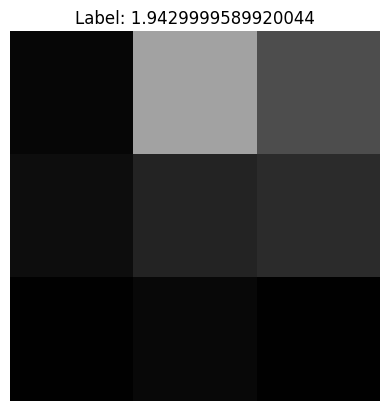

tabular data: tensor([0.1360, 0.2941, 0.0291, 0.0210, 0.0438, 0.0024, 0.6302, 0.1673])


In [34]:
# Assume `test_loader` is a PyTorch DataLoader
# Fetch one batch of images and labels
data_iter = iter(test_loader)
num_data, images, labels = next(data_iter)  # Get one batch (images and labels)

# Select the first tabular data, image and its corresponding label (optional)
num = num_data[0]
image = images[0]  # Shape: (C, H, W)
label = labels[0]  # (Optional, if labels are available)

# Visualization (optional)
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Convert the tensor to a PIL image for visualization
plt.imshow(F.to_pil_image(image))
plt.title(f"Label: {label.item() if labels is not None else 'No label available'}")
plt.axis("off")
plt.show()

print(f"tabular data: {num}")

In [35]:
# Ensure the image has the correct shape for the model
image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device (e.g., GPU)
num = num.unsqueeze(0).to(device)
print("Image shape for model input:", image.shape)
print("Tabular data shape for model input:", num.shape)

Image shape for model input: torch.Size([1, 3, 3, 3])
Tabular data shape for model input: torch.Size([1, 8])


In [36]:
# Function to normalize the attention map
def normalize_attention_map(attention_map):
    # Apply ReLU to remove negative values
    attention_map = np.maximum(attention_map, 0)
    
    # Normalize to [0, 1]
    attention_map -= np.min(attention_map)
    attention_map /= np.max(attention_map)  # Ensure max is 1
    return attention_map

### Multimodal Fusion values

In [ ]:
# Forward pass through the model
with torch.no_grad():
    outputs, attentions = model(num, image)

model.gating.num_gate

### RAW Attention Map

By extracting the attention weights from each attention head at various layers, you can visualize heatmaps over the input image patches. These maps show which regions of the image a particular head or layer attends to.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [94.0..255.0].


Number of patches (excluding CLS token): 9, Patch size: 3


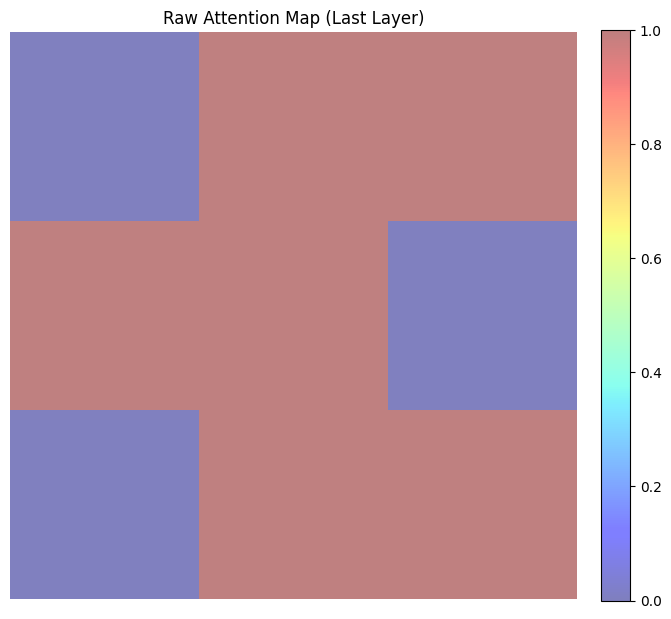

In [ ]:
#1 RAW Attention Map
from PIL import Image  # Import Image module

# Forward pass through the model
with torch.no_grad():
    outputs, attentions = model(num, image)

# Function to visualize attention map with color bar
def visualize_attention(image, attention_map, title="Attention Map"):
    # Ensure the image is in the correct format (C, H, W -> H, W, C)
    if image.ndimension() == 4:  # If the input image has batch size
        image = image[0]  # Use the first image in the batch
    image = image.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format (Height, Width, Channels)
    
    plt.figure(figsize=(8, 8))
    
    # Display the image
    plt.imshow(image)
    
    # Overlay the attention map
    im = plt.imshow(attention_map, cmap="jet", alpha=0.5)  # Overlay attention with transparency
    
    # Add title and hide axes
    plt.title(title)
    plt.axis("off")
    
    # Add color bar for the attention map
    plt.colorbar(im, fraction=0.046, pad=0.04)  # Show the color bar for the attention map
    
    plt.show()

# 1. Raw Attention Map
# Extract attention weights from the last layer, average over all heads
last_layer_attention = attentions[-1]  # Shape: (batch_size, num_heads, num_patches, num_patches)
avg_attention = last_layer_attention.mean(dim=1)  # Average over heads

# Get the shape of avg_attention to determine the number of patches
num_patches = avg_attention.shape[-1]  # Number of patches (including CLS token)

# Calculate the size of the attention map based on number of patches
patch_size = int(np.sqrt(num_patches - 1))  # Exclude CLS token
print(f"Number of patches (excluding CLS token): {num_patches - 1}, Patch size: {patch_size}")

# Extract attention from CLS token to all patches and reshape to a grid
cls_attention = avg_attention[0, 0, 1:].reshape(patch_size, patch_size).detach().cpu().numpy()  # Exclude CLS token itself

# Normalize the attention map
cls_attention_normalized = normalize_attention_map(cls_attention)

# Resize attention map to match image size
cls_attention_resized = np.array(Image.fromarray(cls_attention_normalized).resize((imgs_shape[1], imgs_shape[1]), resample=Image.BILINEAR))

# Visualize Raw Attention Map
visualize_attention(image, cls_attention_resized, title="Raw Attention Map (Last Layer)")

### Attention Rollout

Since attention is compositional through layers, researchers use “attention rollout” techniques to aggregate attention across layers. For instance, one can multiply attention matrices across layers to track how information flows from patches to the CLS token. This can yield a single interpretable map that highlights the most influential patches for the final decision.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [94.0..255.0].


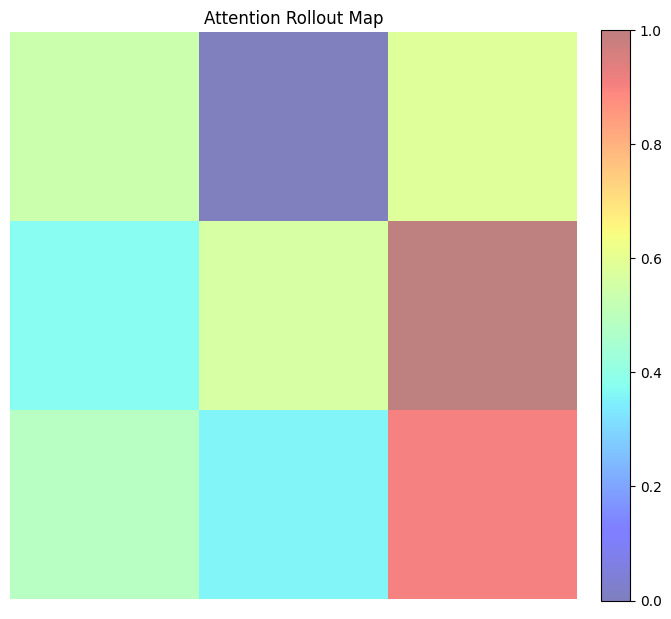

In [38]:
# 2. Attention Rollout
# sxplain brieflyy
def attention_rollout(attentions):
    num_tokens = attentions[0].size(-1)
    eye = torch.eye(num_tokens).unsqueeze(0).to(attentions[0].device)  # Identity matrix for residual connection
    joint_attention = eye
    for attention in attentions:
        avg_attention = attention.mean(dim=1)  # Average over heads
        joint_attention = torch.matmul(joint_attention, avg_attention + eye)  # Residual connection
    return joint_attention

rollout_attention = attention_rollout(attentions)
cls_rollout_attention = rollout_attention[0, 0, 1:].reshape(patch_size, patch_size).detach().cpu().numpy()

# Normalize the rollout attention map
cls_rollout_attention_normalized = normalize_attention_map(cls_rollout_attention)

# Resize rollout attention map to match image size
rollout_attention_resized = np.array(Image.fromarray(cls_rollout_attention_normalized).resize((imgs_shape[1], imgs_shape[1]), resample=Image.BILINEAR))

# Visualize Attention Rollout Map
visualize_attention(image, rollout_attention_resized, title="Attention Rollout Map")

### Gradient based - Grad-Cam

In [ ]:
# Ensure input tensor supports gradients
image.requires_grad_()

# Forward pass to get output and attentions
outputs, attentions = model(image)

# Assuming regression task, extract scalar output
output_scalar = outputs.squeeze()  # Single scalar value for batch size = 1
regression_value = output_scalar.item()

# Extract attention map from the last layer
last_attention_map = attentions[-1]  # Shape: (Batch, Heads, Tokens, Tokens)

# We need gradients w.r.t. this attention map
last_attention_map.requires_grad_()

# Zero gradients in the model
model.zero_grad()

# Backward pass to compute gradients of the regression output
output_scalar.backward()

# Now, last_attention_map.grad contains the gradients
gradients = last_attention_map.grad  # Gradients w.r.t. attention map

# Normalize and visualize the gradients as a heatmap
# Use the mean of the gradients across the heads
pooled_gradients = torch.mean(gradients, dim=1)  # Mean over heads
attention_gradient_map = pooled_gradients.squeeze()  # Shape: (Tokens, Tokens)

# Reshape or resize the gradient map if needed for visualization
# ViT token attention maps may need to be converted back to image space
def normalize_attention_map(attention_map):
    attention_map -= attention_map.min()
    attention_map /= attention_map.max()
    return attention_map

# Normalize and visualize
attention_gradient_map_normalized = normalize_attention_map(attention_gradient_map.cpu().detach().numpy())